In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from statsmodels.stats.multitest import fdrcorrection
sns.set(font='Roboto', style='darkgrid')

In [66]:
feature_names = json.loads(open('utils/lut_dict.txt').read())

In [67]:
for feature in feature_names.keys():
    if 'area' in feature:
        feature_names[feature] = feature_names[feature] + " A"
    elif 'thickness' in feature:
        feature_names[feature] = feature_names[feature] + " T"
    else:
        feature_names[feature] = feature_names[feature]  

In [68]:
# ORGANIZE DATA
#############################################################

# create dataframes
important_features = pd.read_csv("out/important_features.csv")
ml_dataframe = pd.read_csv("stats/ml_dataframe.csv")
print(ml_dataframe.shape)
ml_dataframe = ml_dataframe.dropna(axis=0)
print(ml_dataframe.shape)

# rename columns 
important_features = important_features.rename(columns={'feature': 'importance'})
important_features = important_features.rename(columns={'Unnamed: 0': 'feature'})

# print all important features into a new list
important_features_list = important_features['feature'].tolist()

# save names of features where importance >=5 to a list called top_features
top_features = important_features[important_features['importance'] >= 5]
top_features = top_features['feature'].tolist()

# make separate dataframe for top features' importance 
top_features_importance = important_features[important_features['importance'] >= 5]

# reading LUT
region_names = np.array(list([feature_names[feature] for feature in important_features['feature']]))

# add label column
important_features['feature type'] = np.where(important_features['feature'].str.contains('thickness'), "thickness", 
                                       np.where(important_features['feature'].str.contains('area'), "area", "volume"))
important_features['feature'] = region_names

(152, 421)
(152, 421)


In [69]:
# # generate histogram of all features
# with plt.xkcd():
#     ax1 = sns.catplot(data=important_features, kind="bar", x="importance", y="feature", height=15, aspect=2, hue="feature type", dodge=False, palette=['#5Ef2A8', '#6E8CE3', '#FF9F21'])
#     plt.xticks([0,1,2,3,4,5,6,7,8,9,10])    
#     plt.title("Feature Importance", fontsize=40)
#     plt.xlabel("Importance", fontsize=30)
#     plt.ylabel("Feature", fontsize=30)
#     # plt.savefig('out/important_features.png', dpi=300, bbox_inches='tight')
#     plt.clf()

In [70]:
# FEATURE WEIGHTS
#############################################################

# make a graph to visualize the feature weights data in outs folder ([fold]_feature_weights.csv)
#load df from all folds and merge into one dataframe

#create new dataframe for each fold file

dataframes = []  # List to store the dataframes

for i in range(0,10):
    filename=('out/{}_feature_weights.csv'.format(i))
     # Generate the filename
    df = pd.read_csv(filename)  # Read the CSV file into a dataframe
    dataframes.append(df)

# rename first column of each dataframe to fold #
for i in range(0,10):
    dataframes[i] = dataframes[i].rename(columns={'Unnamed: 0': 'fold #'})
    dataframes[i]['fold #'] = i

# merge all 10 dataframes within dataframes list into a single dataframe
all_weights = pd.concat(dataframes)
all_weights.head()

,fold #,rh_G_temp_sup-G_T_transv_area,lh_S_circular_insula_inf_thickness,rh_S_circular_insula_inf_thickness,rh_S_front_sup_area,lh_G_rectus_thickness,rh_VM,rh_PuM,lh_S_pericallosal_area,lh_PuI,...,lh_G_temp_sup-Lateral_area,rh_G_cuneus_area,rh_S_temporal_sup_area,lh_G_front_inf-Orbital_area,rh_MGN,lh_AV,rh_Pole_temporal_area,rh_S_orbital-H_Shaped_area,lh_S_collat_transv_post_area,lh_HATA
0,0,-0.071184,-0.072614,-0.108120,0.100331,0.204653,-0.491208,-0.156778,0.108842,0.139625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,NaN,NaN,NaN,NaN,NaN,-0.388743,NaN,0.187188,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2,-0.053031,-0.054735,-0.091603,0.133508,0.150992,-0.350524,NaN,0.132780,0.122341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3,NaN,-0.079293,NaN,0.062400,NaN,-0.413438,-0.147736,0.174252,0.115615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4,NaN,-0.066225,-0.074286,0.132953,0.210409,-0.416574,NaN,0.228738,0.135578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# melt
all_weights = pd.melt(all_weights, id_vars=['fold #'], var_name='feature', value_name='weight')
print(all_weights)

     fold #                        feature    weight
0         0  rh_G_temp_sup-G_T_transv_area -0.071184
1         1  rh_G_temp_sup-G_T_transv_area       NaN
2         2  rh_G_temp_sup-G_T_transv_area -0.053031
3         3  rh_G_temp_sup-G_T_transv_area       NaN
4         4  rh_G_temp_sup-G_T_transv_area       NaN
..      ...                            ...       ...
615       5                        lh_HATA       NaN
616       6                        lh_HATA       NaN
617       7                        lh_HATA       NaN
618       8                        lh_HATA       NaN
619       9                        lh_HATA -0.084661

[620 rows x 3 columns]


In [72]:
# make top_weights dataframe where feature is in top_features list
top_weights = all_weights[all_weights['feature'].isin(top_features)]

# abbreviate names
region_names = np.array(list([feature_names[feature] for feature in top_weights['feature']]))
top_weights['feature'] = region_names

#do same for top_features_importance
region_names = np.array(list([feature_names[feature] for feature in top_features_importance['feature']]))
top_features_importance['feature'] = region_names

# add 'importance' column to top_weights datafram where the importance is the importance of that feature based on 'importance' from top_features_importance
top_weights['importance'] = top_weights['feature'].map(top_features_importance.set_index('feature')['importance'])


# abs value
top_weights['weight'] = top_weights['weight'].abs()
top_weights

/tmp/ipykernel_439797/393470608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_weights['feature'] = region_names
/tmp/ipykernel_439797/393470608.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_importance['feature'] = region_names
/tmp/ipykernel_439797/393470608.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,fold #,feature,weight,importance
0,0,R HG A,0.071184,6
1,1,R HG A,NaN,6
2,2,R HG A,0.053031,6
3,3,R HG A,NaN,6
4,4,R HG A,NaN,6
...,...,...,...,...
315,5,L PerCaS T,0.149703,5
316,6,L PerCaS T,0.086525,5
317,7,L PerCaS T,0.101005,5
318,8,L PerCaS T,NaN,5


In [73]:
means = []
print(top_features)
for i, _ in  enumerate(top_features):
    means.append((top_weights.groupby('feature').max().sort_values('weight', ascending=False)['weight'][i]))

print(means)

['rh_VM', 'lh_S_pericallosal_area', 'rh_G_postcentral_area', 'rh_S_front_sup_area', 'lh_G_rectus_thickness', 'rh_L-Sg', 'lh_S_oc_sup&transversal_area', 'rh_G_temp_sup-G_T_transv_area', 'lh_S_circular_insula_inf_thickness', 'lh_PuI', 'rh_CA3-body', 'lh_VPL', 'rh_G_oc-temp_lat-fusifor_area', 'rh_MDm', 'lh_S_pericallosal_thickness', 'rh_S_circular_insula_inf_thickness', 'rh_G_cuneus_thickness']
[0.4912076836070768, 0.3109376436048891, 0.231814063460381, 0.2287375173092509, 0.2104089591135308, 0.1977882526134461, 0.1912069752112344, 0.1697430187577147, 0.1656141199872517, 0.1613074930539552, 0.1564878395249868, 0.1335075939482546, 0.1212129365342661, 0.1195035899951841, 0.0792927996173565, 0.0787044300681327, 0.039872997677488]


In [74]:
# network colours for bar plot
palette_dict = {'R VM V': '#c5ed85', 'L PerCaS A': '#ff8e52', 'R PosCG A': '#5edb69', 'R SupFS A': '#ff8e52',
                'L RG T': '#6d8ded', 'R L-Sg V': '#ff6376', 'L TOS A': '#ff8e52', 'R HG A': '#5edb69',
                'L InfCrInS T': '#ff8e52', 'L PuI V': '#ff6376', 'R CA3 Body V': '#6d8ded', 'L VPL V': '#5edb69',
                'R FuG A': '#6d8ded', 'R MDm V': '#a773de','L PerCaS T': '#ff8e52', 'R InfCrInS T': '#ff8e52', 
                'R Cun T': '#ff6376'}

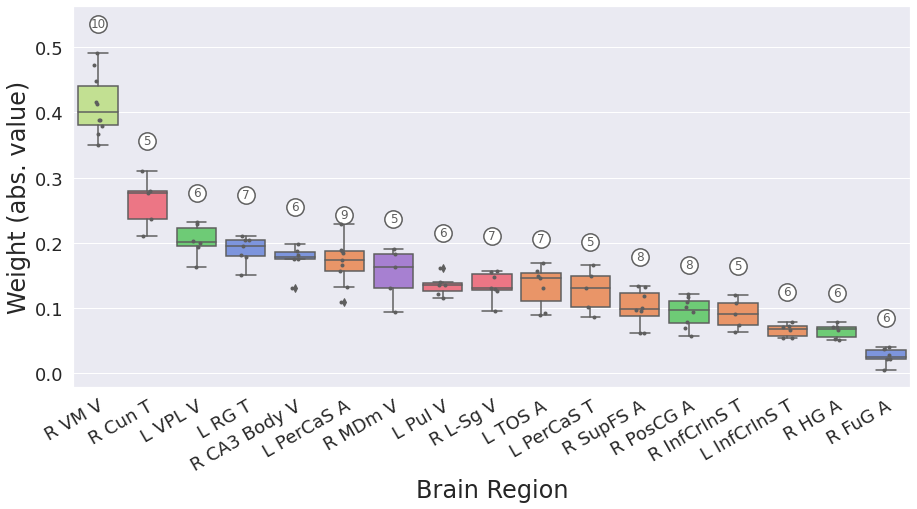

In [75]:
fig = plt.figure(figsize=(15, 7))

# boxplot
ax=sns.boxplot(data=top_weights, x="feature", y="weight", palette=palette_dict, order=top_weights.groupby('feature').mean()
               .sort_values('weight', ascending=False).index)

# For gray outline:: boxprops={'edgecolor':'gray'}, flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"},

# add stripplot
sns.set_style("darkgrid")
sns.stripplot(data=top_weights, x="feature", y="weight", size=4, color='#5E5E5E', order=top_weights.groupby('feature')
              .mean().sort_values('weight', ascending=False).index)

# save axis labels and means in separate list
xlabels = top_weights.groupby('feature').mean().sort_values('weight', ascending=False)
xlabels_list = xlabels.index.tolist()
xlabels_means = xlabels['weight'].tolist()

xlabels_importance = [10, 5, 6, 7, 6, 9, 5, 6, 7, 7, 5, 8, 8, 5, 6, 6, 6]

plt.xticks(rotation=30,size=18,rotation_mode="anchor", ha="right", ticks=np.arange(0, len(xlabels), 1))
plt.yticks(size=18)

plt.xlabel('Brain Region', size=24)
plt.ylabel('Weight (abs. value)', size=24)

# max weight of each feature
xlabels_max = top_weights.groupby('feature').max().sort_values('weight', ascending=False)
max_weights = []
for index, row in xlabels_max.iterrows():
    max_weights.append(row['weight'])

# fold labels
for i,_ in enumerate(max_weights):
    plt.text(x=i, y=(max_weights[i]+0.04), s=xlabels_importance[i], color='#5E5E5E', ha="center", fontsize=12)
    plt.scatter(x=i, y=(max_weights[i]+0.045), s=300, color='white', zorder=2, edgecolor='#5E5E5E', linewidth=1.5)


plt.savefig('out/feature_weights.png', dpi=400, bbox_inches='tight')

In [76]:
# parse healthy controls data

hc_dataframe = pd.read_csv("hc/hc_dataframe.csv")
hc_dataframe_top = hc_dataframe[top_features]
hc_dataframe_top['diagnosis'] = 'HC'
hc_dataframe_top


/tmp/ipykernel_439797/2895246533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc_dataframe_top['diagnosis'] = 'HC'


,rh_VM,lh_S_pericallosal_area,rh_G_postcentral_area,rh_S_front_sup_area,lh_G_rectus_thickness,rh_L-Sg,lh_S_oc_sup&transversal_area,rh_G_temp_sup-G_T_transv_area,lh_S_circular_insula_inf_thickness,lh_PuI,rh_CA3-body,lh_VPL,rh_G_oc-temp_lat-fusifor_area,rh_MDm,lh_S_pericallosal_thickness,rh_S_circular_insula_inf_thickness,rh_G_cuneus_thickness,diagnosis
0,0.018521,0.565592,0.824187,1.241813,0.001860,0.016402,0.489534,0.141744,0.001901,0.173722,0.060476,0.555752,0.696964,0.608144,0.000992,0.001990,0.001331,HC
1,0.017816,0.575520,0.837758,1.227606,0.001689,0.013953,0.555102,0.196519,0.001851,0.148235,0.064165,0.604794,0.886250,0.598251,0.000877,0.001717,0.001110,HC
2,0.020553,0.482682,0.755751,1.151451,0.001904,0.010825,0.527600,0.156141,0.001940,0.115163,0.071395,0.589251,0.848437,0.592057,0.001090,0.002036,0.001393,HC
3,0.021410,0.614891,1.089622,1.057974,0.002048,0.014945,0.557621,0.166533,0.002310,0.146390,0.069752,0.571503,0.979605,0.592580,0.001265,0.002068,0.001645,HC
4,0.022186,0.609263,0.856074,1.016688,0.001298,0.020681,0.606051,0.152584,0.001383,0.122679,0.065523,0.533863,0.774161,0.469631,0.000982,0.001550,0.001024,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.014716,0.599495,0.832274,1.145988,0.001914,0.015021,0.461976,0.166885,0.001929,0.125019,0.082836,0.495697,0.730567,0.490730,0.001064,0.001870,0.001470,HC
70,0.013155,0.723550,1.048945,1.280022,0.001788,0.011098,0.626537,0.173140,0.001985,0.133628,0.064987,0.547097,0.570621,0.445239,0.001060,0.001808,0.001228,HC
71,0.017003,0.621188,0.959129,1.062661,0.001618,0.013285,0.506587,0.132833,0.001580,0.111293,0.078295,0.498409,0.914201,0.455409,0.000897,0.001720,0.001251,HC
72,0.016384,0.446412,0.857340,1.296885,0.001484,0.018435,0.416651,0.250105,0.001481,0.141753,0.073513,0.589272,0.952346,0.468499,0.000886,0.001351,0.001016,HC


In [77]:
# create dataframe with only top features of MS/MSTN
top_features_dataframe = ml_dataframe[top_features]
top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']

# add hc_dataframe_top to top_features_dataframe
top_features_dataframe_all = top_features_dataframe.append(hc_dataframe_top)
top_features_dataframe_all = top_features_dataframe_all.melt(id_vars=['diagnosis'], var_name='feature', value_name='value').fillna(0)
top_features_dataframe_all['feature'] = [feature_names[feature] for feature in top_features_dataframe_all['feature']]

top_features_dataframe = top_features_dataframe.melt(id_vars=['diagnosis'], var_name='feature', value_name='value').fillna(0)
top_features_dataframe['feature'] = [feature_names[feature] for feature in top_features_dataframe['feature']]

/tmp/ipykernel_439797/4017581923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']


In [78]:
# make dataframe for each diagnosis
top_features_dataframe_ms = top_features_dataframe_all[top_features_dataframe_all['diagnosis'] == 'MS']
top_features_dataframe_hc = top_features_dataframe_all[top_features_dataframe_all['diagnosis'] == 'HC']
top_features_dataframe_mstn = top_features_dataframe_all[top_features_dataframe_all['diagnosis'] == 'MS-TN']

# make dataframe for each combo of two diagnoses
top_features_dataframe_hc_ms = top_features_dataframe_hc.append(top_features_dataframe_ms)
top_features_dataframe_hc_mstn = top_features_dataframe_hc.append(top_features_dataframe_mstn)
top_features_dataframe_ms_mstn = top_features_dataframe_ms.append(top_features_dataframe_mstn)
# rename everything in diagnosis column to ms/mstn
top_features_dataframe_ms_mstn['diagnosis'] = 'MS/MS-TN'
top_features_dataframe_hc_ms_mstn = top_features_dataframe_hc.append(top_features_dataframe_ms_mstn)

# reset ms_mstn dataframe
top_features_dataframe_ms_mstn = top_features_dataframe_ms.append(top_features_dataframe_mstn)
top_features_dataframe_all = top_features_dataframe_hc_ms.append(top_features_dataframe_mstn)

In [79]:
# T-TEST for MS vs MSTN
#############################################################
print(top_features_dataframe)
# melt and organize dataframe for top features
#top_features_dataframe = top_features_dataframe.melt(id_vars=['diagnosis'], var_name='feature', value_name='value').fillna(0)
#top_features_dataframe['feature'] = [feature_names[feature] for feature in top_features_dataframe['feature']]

# set up groups for t-test
ms_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS']
ms_tn_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS-TN']

     diagnosis  feature     value
0        MS-TN   R VM V  0.015654
1        MS-TN   R VM V  0.013405
2        MS-TN   R VM V  0.014779
3        MS-TN   R VM V  0.013061
4        MS-TN   R VM V  0.011455
...        ...      ...       ...
2579        MS  R Cun T  0.001391
2580        MS  R Cun T  0.001273
2581        MS  R Cun T  0.001244
2582        MS  R Cun T  0.001050
2583        MS  R Cun T  0.001072

[2584 rows x 3 columns]


KeyError: 'R VM V'

In [ ]:
# t-test for ms vs. ms-tn

p_vals = []
p_corrected = []
stats_vals = []

# running t-test on top features
for feature in top_features:
    input_ms = ms_dataframe[feature]
    input_ms_tn = ms_tn_dataframe[feature]
    ttest1 = stats.ttest_ind(input_ms, input_ms_tn, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
    #nan_policy='propagate' when all data there
    p_vals.append(ttest1.pvalue)
    stats_vals.append(ttest1.statistic)

# correct p-values for multiple tests

rejected_pval, p_corrected = fdrcorrection(p_vals, alpha=0.05, method='indep')

# replace rejected p-values with "NS"
for i in range(len(p_corrected)):
    if rejected_pval[i] == False:
        p_corrected[i] = 1
    else:
        p_corrected[i] = p_corrected[i]

# save p_corrected of top_features to a csv
p_corrected_df = pd.DataFrame(p_corrected, columns=['p_corrected'])
p_corrected_df['feature'] = top_features

# save p_corrected of top features to a csv
p_corrected_df.to_csv('out/p_corrected.csv')

# copy df into new one  
p_corrected_df_values = p_corrected_df.copy()

p_corrected_df['p_corrected'] = ['NS' if p_corrected == 1 else '*' if p_corrected > 0.01 
                                 else '**' if p_corrected > 0.001 else '***' for p_corrected in p_corrected_df['p_corrected']]
p_values_codes = p_corrected_df['p_corrected'].tolist()

print(p_values_codes)
print(important_features_list)
pval_dict = {important_features_list[i]: p_values_codes[i] for i in range(len(p_values_codes))}
print(pval_dict)

In [ ]:
# t-test for hc vs. ms

p_vals = []
p_corrected = []
stats_vals = []

# running t-test on top features
for feature in top_features:
    input_ms = ms_dataframe[feature]
    input_hc = hc_dataframe[feature]
    ttest1 = stats.ttest_ind(input_ms, input_hc, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
    #nan_policy='propagate' when all data there
    p_vals.append(ttest1.pvalue)
    stats_vals.append(ttest1.statistic)

# correct p-values for multiple tests

rejected_pval, p_corrected = fdrcorrection(p_vals, alpha=0.05, method='indep')

# replace rejected p-values with "NS"
for i in range(len(p_corrected)):
    if rejected_pval[i] == False:
        p_corrected[i] = 1
    else:
        p_corrected[i] = p_corrected[i]

# save p_corrected of top_features to a csv
p_corrected_df = pd.DataFrame(p_corrected, columns=['p_corrected'])
p_corrected_df['feature'] = top_features

# save p_corrected of top features to a csv
p_corrected_df.to_csv('out/p_corrected.csv')

# copy df into new one  
p_corrected_df_values = p_corrected_df.copy()

p_corrected_df['p_corrected'] = ['NS' if p_corrected == 1 else '*' if p_corrected > 0.01 
                                 else '**' if p_corrected > 0.001 else '***' for p_corrected in p_corrected_df['p_corrected']]
p_values_codes = p_corrected_df['p_corrected'].tolist()

print(p_values_codes)
print(important_features_list)
pval_dict = {important_features_list[i]: p_values_codes[i] for i in range(len(p_values_codes))}
print(pval_dict)

In [ ]:
# t-test for hc vs. ms-tn

p_vals = []
p_corrected = []
stats_vals = []

# running t-test on top features
for feature in top_features:
    input_ms_tn = ms_tn_dataframe[feature]
    input_hc = hc_dataframe[feature]
    ttest1 = stats.ttest_ind(input_ms_tn, input_hc, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
    #nan_policy='propagate' when all data there
    p_vals.append(ttest1.pvalue)
    stats_vals.append(ttest1.statistic)

# correct p-values for multiple tests

rejected_pval, p_corrected = fdrcorrection(p_vals, alpha=0.05, method='indep')

# replace rejected p-values with "NS"
for i in range(len(p_corrected)):
    if rejected_pval[i] == False:
        p_corrected[i] = 1
    else:
        p_corrected[i] = p_corrected[i]

# save p_corrected of top_features to a csv
p_corrected_df = pd.DataFrame(p_corrected, columns=['p_corrected'])
p_corrected_df['feature'] = top_features

# save p_corrected of top features to a csv
p_corrected_df.to_csv('out/p_corrected.csv')

# copy df into new one  
p_corrected_df_values = p_corrected_df.copy()

p_corrected_df['p_corrected'] = ['NS' if p_corrected == 1 else '*' if p_corrected > 0.01 
                                 else '**' if p_corrected > 0.001 else '***' for p_corrected in p_corrected_df['p_corrected']]
p_values_codes = p_corrected_df['p_corrected'].tolist()

print(p_values_codes)
print(important_features_list)
pval_dict = {important_features_list[i]: p_values_codes[i] for i in range(len(p_values_codes))}
print(pval_dict)

In [ ]:
# t-test for hc vs. ms+ms-tn

p_vals = []
p_corrected = []
stats_vals = []

# running t-test on top features
for feature in top_features:
    input_ms_mstn = ml_dataframe[feature]
    input_hc = hc_dataframe[feature]
    ttest1 = stats.ttest_ind(input_ms_mstn, input_hc, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
    #nan_policy='propagate' when all data there
    p_vals.append(ttest1.pvalue)
    stats_vals.append(ttest1.statistic)

# correct p-values for multiple tests

rejected_pval, p_corrected = fdrcorrection(p_vals, alpha=0.05, method='indep')

# replace rejected p-values with "NS"
for i in range(len(p_corrected)):
    if rejected_pval[i] == False:
        p_corrected[i] = 1
    else:
        p_corrected[i] = p_corrected[i]

# save p_corrected of top_features to a csv
p_corrected_df = pd.DataFrame(p_corrected, columns=['p_corrected'])
p_corrected_df['feature'] = top_features

# save p_corrected of top features to a csv
p_corrected_df.to_csv('out/p_corrected.csv')

# copy df into new one  
p_corrected_df_values = p_corrected_df.copy()

p_corrected_df['p_corrected'] = ['NS' if p_corrected == 1 else '*' if p_corrected > 0.01 
                                 else '**' if p_corrected > 0.001 else '***' for p_corrected in p_corrected_df['p_corrected']]
p_values_codes = p_corrected_df['p_corrected'].tolist()

print(p_values_codes)
print(important_features_list)
pval_dict = {important_features_list[i]: p_values_codes[i] for i in range(len(p_values_codes))}
print(pval_dict)

In [ ]:
# univariate for ms vs. mstn
top_features_dataframe=top_features_dataframe_ms_mstn

top_features_dataframe_hippo = top_features_dataframe[top_features_dataframe['feature'].str.contains('CA1|CA2|CA3|CA4|DG|SUB|ERC|Fimbria')]
top_features_dataframe_thal = top_features_dataframe[top_features_dataframe['feature'].str.contains('VPL|PuI|VM|VPL|VPM|PuM|VA|VL|PuL|MDm|L-Sg')]
top_features_dataframe_v = pd.concat([top_features_dataframe_hippo, top_features_dataframe_thal])

top_features_dataframe_t = top_features_dataframe[top_features_dataframe['feature'].str.endswith('T')]
top_features_dataframe_a = top_features_dataframe[top_features_dataframe['feature'].str.endswith('A')]

# remove the V T and A from the end of the feature names
top_features_dataframe_hippo['feature'] = top_features_dataframe_hippo['feature'].str[:-2]
top_features_dataframe_thal['feature'] = top_features_dataframe_thal['feature'].str[:-2]
top_features_dataframe_v['feature'] = top_features_dataframe_v['feature'].str[:-2]
top_features_dataframe_t['feature'] = top_features_dataframe_t['feature'].str[:-2]
top_features_dataframe_a['feature'] = top_features_dataframe_a['feature'].str[:-2]

# print unique values of top features thal and hippo
print(top_features_dataframe_v['feature'].unique())
print(top_features_dataframe_t['feature'].unique())
print(top_features_dataframe_a['feature'].unique())

# figures for univariate of ms vs. mstn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 15))
plt.title('Cortical Area', size=40)
sns.set_style("whitegrid")
ax=sns.boxplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()

sns.set_style("whitegrid")
plt.savefig('out/cortical_area.png', dpi=400, bbox_inches='tight')

#cortical thickness
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Cortical Thickness', size=40)
ax=sns.boxplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/cortical_thickness.png', dpi=400, bbox_inches='tight')

#subcor vol
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Subcortical Volume', size=40)
ax=sns.boxplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
    #add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff"},
                    dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/subcortical_volume', dpi=300, bbox_inches='tight')

In [ ]:
# figures for univariate of hc vs. ms
top_features_dataframe=top_features_dataframe_hc_ms

top_features_dataframe_hippo = top_features_dataframe[top_features_dataframe['feature'].str.contains('CA1|CA2|CA3|CA4|DG|SUB|ERC|Fimbria')]
top_features_dataframe_thal = top_features_dataframe[top_features_dataframe['feature'].str.contains('VPL|PuI|VM|VPL|VPM|PuM|VA|VL|PuL|MDm|L-Sg')]
top_features_dataframe_v = pd.concat([top_features_dataframe_hippo, top_features_dataframe_thal])

top_features_dataframe_t = top_features_dataframe[top_features_dataframe['feature'].str.endswith('T')]
top_features_dataframe_a = top_features_dataframe[top_features_dataframe['feature'].str.endswith('A')]

# remove the V T and A from the end of the feature names
top_features_dataframe_hippo['feature'] = top_features_dataframe_hippo['feature'].str[:-2]
top_features_dataframe_thal['feature'] = top_features_dataframe_thal['feature'].str[:-2]
top_features_dataframe_v['feature'] = top_features_dataframe_v['feature'].str[:-2]
top_features_dataframe_t['feature'] = top_features_dataframe_t['feature'].str[:-2]
top_features_dataframe_a['feature'] = top_features_dataframe_a['feature'].str[:-2]

# print unique values of top features thal and hippo
print(top_features_dataframe_v['feature'].unique())
print(top_features_dataframe_t['feature'].unique())
print(top_features_dataframe_a['feature'].unique())

plt.figure(figsize=(10, 15))
plt.title('Cortical Area', size=40)
sns.set_style("whitegrid")
ax=sns.boxplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "HC":"#bfbfbf"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()

sns.set_style("whitegrid")
plt.savefig('out/cortical_area.png', dpi=400, bbox_inches='tight')

#cortical thickness
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Cortical Thickness', size=40)
ax=sns.boxplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "HC":"#bfbfbf"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/cortical_thickness.png', dpi=400, bbox_inches='tight')

#subcor vol
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Subcortical Volume', size=40)
ax=sns.boxplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
    #add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "HC":"#bfbfbf"},
                    dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/subcortical_volume', dpi=300, bbox_inches='tight')

In [ ]:
# figures for univariate of hc vs. ms-tn
top_features_dataframe=top_features_dataframe_hc_mstn

top_features_dataframe_hippo = top_features_dataframe[top_features_dataframe['feature'].str.contains('CA1|CA2|CA3|CA4|DG|SUB|ERC|Fimbria')]
top_features_dataframe_thal = top_features_dataframe[top_features_dataframe['feature'].str.contains('VPL|PuI|VM|VPL|VPM|PuM|VA|VL|PuL|MDm|L-Sg')]
top_features_dataframe_v = pd.concat([top_features_dataframe_hippo, top_features_dataframe_thal])

top_features_dataframe_t = top_features_dataframe[top_features_dataframe['feature'].str.endswith('T')]
top_features_dataframe_a = top_features_dataframe[top_features_dataframe['feature'].str.endswith('A')]

# remove the V T and A from the end of the feature names
top_features_dataframe_hippo['feature'] = top_features_dataframe_hippo['feature'].str[:-2]
top_features_dataframe_thal['feature'] = top_features_dataframe_thal['feature'].str[:-2]
top_features_dataframe_v['feature'] = top_features_dataframe_v['feature'].str[:-2]
top_features_dataframe_t['feature'] = top_features_dataframe_t['feature'].str[:-2]
top_features_dataframe_a['feature'] = top_features_dataframe_a['feature'].str[:-2]

# print unique values of top features thal and hippo
print(top_features_dataframe_v['feature'].unique())
print(top_features_dataframe_t['feature'].unique())
print(top_features_dataframe_a['feature'].unique())

plt.figure(figsize=(10, 15))
plt.title('Cortical Area', size=40)
sns.set_style("whitegrid")
ax=sns.boxplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS-TN":"#70e0ff", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS-TN":"#70e0ff", "HC":"#bfbfbf"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()

sns.set_style("whitegrid")
plt.savefig('out/cortical_area.png', dpi=400, bbox_inches='tight')

#cortical thickness
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Cortical Thickness', size=40)
ax=sns.boxplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS-TN":"#70e0ff", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS-TN":"#70e0ff", "HC":"#bfbfbf"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/cortical_thickness.png', dpi=400, bbox_inches='tight')

#subcor vol
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Subcortical Volume', size=40)
ax=sns.boxplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS-TN":"#70e0ff", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
    #add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS-TN":"#70e0ff", "HC":"#bfbfbf"},
                    dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/subcortical_volume', dpi=300, bbox_inches='tight')

In [ ]:
# figures for univariate of hc vs. ms/ms-tn
top_features_dataframe=top_features_dataframe_hc_ms_mstn

top_features_dataframe_hippo = top_features_dataframe[top_features_dataframe['feature'].str.contains('CA1|CA2|CA3|CA4|DG|SUB|ERC|Fimbria')]
top_features_dataframe_thal = top_features_dataframe[top_features_dataframe['feature'].str.contains('VPL|PuI|VM|VPL|VPM|PuM|VA|VL|PuL|MDm|L-Sg')]
top_features_dataframe_v = pd.concat([top_features_dataframe_hippo, top_features_dataframe_thal])

top_features_dataframe_t = top_features_dataframe[top_features_dataframe['feature'].str.endswith('T')]
top_features_dataframe_a = top_features_dataframe[top_features_dataframe['feature'].str.endswith('A')]

# remove the V T and A from the end of the feature names
top_features_dataframe_hippo['feature'] = top_features_dataframe_hippo['feature'].str[:-2]
top_features_dataframe_thal['feature'] = top_features_dataframe_thal['feature'].str[:-2]
top_features_dataframe_v['feature'] = top_features_dataframe_v['feature'].str[:-2]
top_features_dataframe_t['feature'] = top_features_dataframe_t['feature'].str[:-2]
top_features_dataframe_a['feature'] = top_features_dataframe_a['feature'].str[:-2]

# print unique values of top features thal and hippo
print(top_features_dataframe_v['feature'].unique())
print(top_features_dataframe_t['feature'].unique())
print(top_features_dataframe_a['feature'].unique())

plt.figure(figsize=(10, 15))
plt.title('Cortical Area', size=40)
sns.set_style("whitegrid")
ax=sns.boxplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS/MS-TN":"#73e06c", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS/MS-TN":"#73e06c", "HC":"#bfbfbf"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()

sns.set_style("whitegrid")
plt.savefig('out/cortical_area.png', dpi=400, bbox_inches='tight')

#cortical thickness
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Cortical Thickness', size=40)
ax=sns.boxplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS/MS-TN":"#73e06c", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS/MS-TN":"#73e06c", "HC":"#bfbfbf"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/cortical_thickness.png', dpi=400, bbox_inches='tight')

#subcor vol
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Subcortical Volume', size=40)
ax=sns.boxplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS/MS-TN":"#73e06c", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
    #add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS/MS-TN":"#73e06c", "HC":"#bfbfbf"},
                    dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/subcortical_volume', dpi=300, bbox_inches='tight')

In [ ]:
# make separate dataframes depending on region for hc vs. ms+mstn
top_features_dataframe=top_features_dataframe_all

top_features_dataframe_hippo = top_features_dataframe[top_features_dataframe['feature'].str.contains('CA1|CA2|CA3|CA4|DG|SUB|ERC|Fimbria')]
top_features_dataframe_thal = top_features_dataframe[top_features_dataframe['feature'].str.contains('VPL|PuI|VM|VPL|VPM|PuM|VA|VL|PuL|MDm|L-Sg')]
top_features_dataframe_v = pd.concat([top_features_dataframe_hippo, top_features_dataframe_thal])

top_features_dataframe_t = top_features_dataframe[top_features_dataframe['feature'].str.endswith('T')]
top_features_dataframe_a = top_features_dataframe[top_features_dataframe['feature'].str.endswith('A')]

# remove the V T and A from the end of the feature names
top_features_dataframe_hippo['feature'] = top_features_dataframe_hippo['feature'].str[:-2]
top_features_dataframe_thal['feature'] = top_features_dataframe_thal['feature'].str[:-2]
top_features_dataframe_v['feature'] = top_features_dataframe_v['feature'].str[:-2]
top_features_dataframe_t['feature'] = top_features_dataframe_t['feature'].str[:-2]
top_features_dataframe_a['feature'] = top_features_dataframe_a['feature'].str[:-2]

# print unique values of top features thal and hippo
print(top_features_dataframe_v['feature'].unique())
print(top_features_dataframe_t['feature'].unique())
print(top_features_dataframe_a['feature'].unique())

# figures for univariate of ms vs. mstn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 15))
plt.title('Cortical Area', size=40)
sns.set_style("whitegrid")
ax=sns.boxplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff", "HC":"#bfbfbf"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()

sns.set_style("whitegrid")
plt.savefig('out/cortical_area.png', dpi=400, bbox_inches='tight')

#cortical thickness
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Cortical Thickness', size=40)
ax=sns.boxplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
#add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff", "HC":"#bfbfbf"},
                dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/cortical_thickness.png', dpi=400, bbox_inches='tight')

#subcor vol
plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")
plt.title('Subcortical Volume', size=40)
ax=sns.boxplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff", "HC":"#bfbfbf"}, boxprops={'edgecolor':'gray'},  flierprops={"markerfacecolor": "gray", "markeredgecolor":"gray"}, medianprops={"color": "gray"}, whiskerprops={"color": "gray"}, capprops={"color": "gray"})
plt.setp(ax.get_xticklabels(), rotation=30, size=25)
plt.setp(ax.get_yticklabels(), size=25)
    #add scatterplot on top of boxplot
ax1=sns.stripplot(data=top_features_dataframe_v, x="feature", y="value", hue="diagnosis", palette={"MS":"#FFB453", "MS-TN":"#70e0ff", "HC":"#bfbfbf"},
                    dodge=True, size=5, edgecolor="white", linewidth=1)
ax.set_yscale('log')
ax.set_xlabel(" ", size=30)
ax.set_ylabel('Size', size=30)
ax.get_legend().remove()
sns.set_style("whitegrid")
plt.savefig('out/subcortical_volume.png', dpi=300, bbox_inches='tight')

In [ ]:
# run stats on ms_studies demographic data

ms_studies = pd.read_csv('stats/MS_studies.csv')
print(ms_studies.shape)
# drop patients missing featural data
ms_studies = ms_studies[ms_studies['id'] != 'tl_0139']
ms_studies = ms_studies[ms_studies['id'] != 'tl_0440']
ms_studies = ms_studies[ms_studies['id'] != 'ms_19']
ms_studies = ms_studies[ms_studies['id'] != 'ms_75']
print(ms_studies.shape)

# make two dataframes based on ms or ms-tn diagnosis
ms_studies_ms = ms_studies[ms_studies['diagnosis'] == 'MS']
ms_studies_mstn = ms_studies[ms_studies['diagnosis'] == 'MS-TN']

# calculate mean and standard deviation of age and duration of ms from ms and mstn dataframes and print,also sexes
print('MS sex:\n{}'.format(ms_studies_ms['sex'].value_counts()))
print("MS mean age: {} std: {}".format(ms_studies_ms['age'].mean(), ms_studies_ms['age'].std()))
print("MS mean MS duration: {} std: {}\n".format(ms_studies_ms['duration_of_ms'].mean(), ms_studies_ms['duration_of_ms'].std()))
print('MS-TN sex:\n{}'.format(ms_studies_mstn['sex'].value_counts()))
print("MS-TN mean age: {} std: {}".format(ms_studies_mstn['age'].mean(), ms_studies_mstn['age'].std()))
print("MS-TN mean MS duration: {} std: {}".format(ms_studies_mstn['duration_of_ms'].mean(), ms_studies_mstn['duration_of_ms'].std()))
print("MS-TN mean pain duration: {} std: {}".format(ms_studies_mstn['duration_of_pain'].mean(), ms_studies_mstn['duration_of_pain'].std()))
print("MS-TN laterality: {}".format(ms_studies_mstn['side_of_pain'].value_counts()))